# Skin Cancer

In [131]:
import kagglehub
import shutil
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

## 1.1 downloading the dataset

In [132]:
try:
    path = kagglehub.dataset_download("rm1000/skin-cancer-isic-images")
    shutil.copytree(path, './data/skin-cancer')
except:
    print("folder already exists!")

folder already exists!


## read and resize

In [133]:
all_ds = tf.keras.utils.image_dataset_from_directory(
  "./data/skin-cancer",
  color_mode='rgb',
  seed=123,
  image_size=(30, 30),
  batch_size=32,
  shuffle=True)

Found 3297 files belonging to 2 classes.


## Blancing the dataset with augmentation

In [134]:
def getImgCountPerClass(dataset):
    class1=0
    all=0
    for images, labels in dataset:
        class1+=(sum(labels[i].numpy() for i in range(images.shape[0])))
        all+=images.shape[0]
    return class1, all-class1

In [135]:
print(getImgCountPerClass(all_ds))

(1497, 1800)


In [136]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def separate_classes(dataset):
    class_0_images, class_0_labels = [], []
    class_1_images, class_1_labels = [], []

    for images, labels in dataset:
        for i in range(images.shape[0]):
            if labels[i].numpy() == 0:
                class_0_images.append(images[i].numpy())
                class_0_labels.append(labels[i].numpy())
            else:
                class_1_images.append(images[i].numpy())
                class_1_labels.append(labels[i].numpy())
    
    return (np.array(class_0_images), np.array(class_0_labels)), (np.array(class_1_images), np.array(class_1_labels))

def augment_class(images, labels, target_count, datagen):
    augmented_images, augmented_labels = [], []
    while len(augmented_images) < target_count:
        random.shuffle(images)
        for i in range(len(images)):
            augmented_image = datagen.random_transform(images[i])
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images), np.array(augmented_labels)

def balance_classes(dataset, datagen, target_count):
    (class_0_images, class_0_labels), (class_1_images, class_1_labels) = separate_classes(dataset)

    if len(class_0_labels) < target_count:
        class_0_images, class_0_labels = augment_class(class_0_images, class_0_labels, target_count, datagen)
    if len(class_1_labels) < target_count:
        class_1_images, class_1_labels = augment_class(class_1_images, class_1_labels, target_count, datagen)

    balanced_images = np.concatenate([class_0_images, class_1_images], axis=0)
    balanced_labels = np.concatenate([class_0_labels, class_1_labels], axis=0)

    indices = np.arange(len(balanced_labels))
    np.random.shuffle(indices)
    balanced_images = balanced_images[indices]
    balanced_labels = balanced_labels[indices]

    return tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))

all_ds = balance_classes(all_ds, datagen, int(max(getImgCountPerClass(all_ds))*3)).batch(32)

In [137]:
test_ds = all_ds.take(len(all_ds)//10)
val_ds = all_ds.skip(len(all_ds)//10)
val_ds = val_ds.take(len(val_ds)//9)
train_ds = all_ds.skip(len(all_ds)//5)

In [138]:
train_ds = balance_classes(train_ds, datagen, max(getImgCountPerClass(train_ds))).batch(32)
# val_ds = balance_classes(val_ds, datagen, max(getImgCountPerClass(val_ds))).batch(32)
# test_ds = balance_classes(test_ds, datagen, max(getImgCountPerClass(test_ds))).batch(32)

In [139]:
print(getImgCountPerClass(val_ds))

(503, 553)


## normalization

In [140]:
import matplotlib.pyplot as plt

def preprocess_image(image, label):
    # image = tf.image.rgb_to_grayscale(image)
    image = image / 255.0
    # image = tf.image.convert_image_dtype(image, tf.float32) 
    # image = (image - tf.reduce_mean(image)) / tf.math.reduce_std(image)
    return image, label

train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

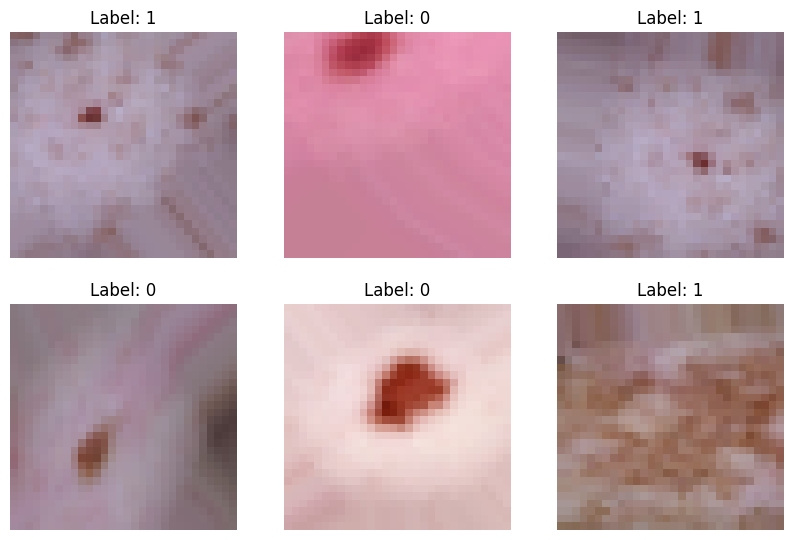

In [141]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i].numpy()}')
        plt.axis('off')
    plt.show()

## Tools for Result Analysis

In [166]:
def plt_acc_loss(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
def plt_roc(model):
    y_true = np.concatenate([y for x, y in test_ds], axis=0) 
    y_pred_proba = model.predict(test_ds).ravel()
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba) 
    roc_auc = auc(fpr, tpr)
    plt.figure() 
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') 
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('Receiver Operating Characteristic (ROC) Curve') 
    plt.legend(loc="lower right")

def plt_confusion(model):
    test_labels = np.concatenate([y for x, y in test_ds], axis=0)
    test_predictions = model.predict(test_ds)
    test_pred_classes = (test_predictions > 0.5).astype(int).ravel()
    cm = confusion_matrix(test_labels, test_pred_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return test_labels, test_pred_classes

## Proposed model without modification

In [143]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2),padding="same"))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu', use_bias=True))
model.add(Dense(units=32, activation='relu', use_bias=True))
model.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_79 (Conv2D)              │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,385 (517.13 KB)

 Trainable params: 132,385 (517.13 KB)

 Non-trainable params: 0 (0.00 B)

In [144]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=32)

test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7259 - loss: 0.5295 - val_accuracy: 0.8153 - val_loss: 0.3877
Epoch 2/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8429 - loss: 0.3639 - val_accuracy: 0.8523 - val_loss: 0.3579
Epoch 3/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8425 - loss: 0.3637 - val_accuracy: 0.8352 - val_loss: 0.3671
Epoch 4/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8664 - loss: 0.3175 - val_accuracy: 0.8381 - val_loss: 0.3519
Epoch 5/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8711 - loss: 0.3060 - val_accuracy: 0.8580 - val_loss: 0.3092
Epoch 6/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8809 - loss: 0.2781 - val_accuracy: 0.8703 - val_loss: 0.2961
Epoch 7/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8932 - loss: 0.2545 - val_accuracy: 0.8665 - val_loss: 0.3039
Epoch 8/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8968 - loss: 0.2334 - val_accuracy: 0.

### Results

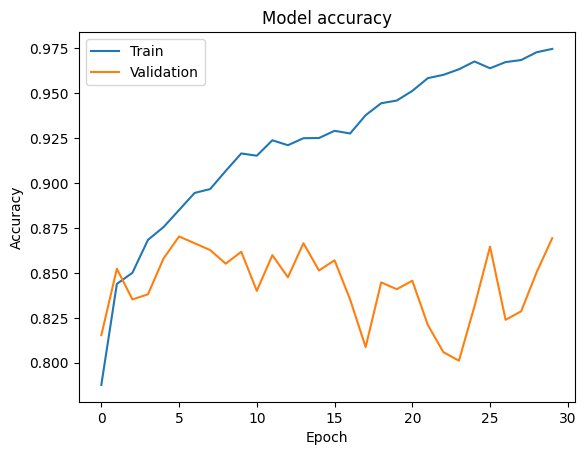

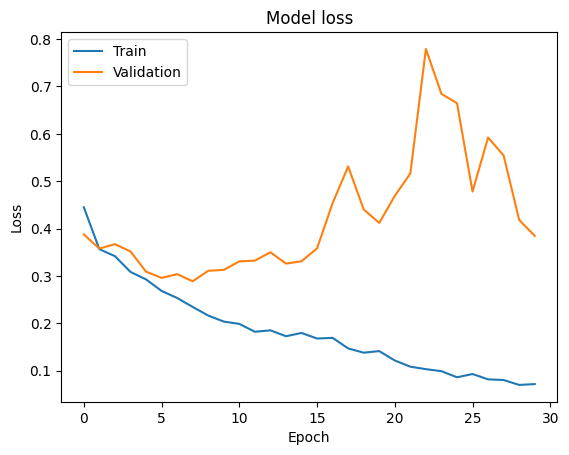

In [145]:
plt_acc_loss(history)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


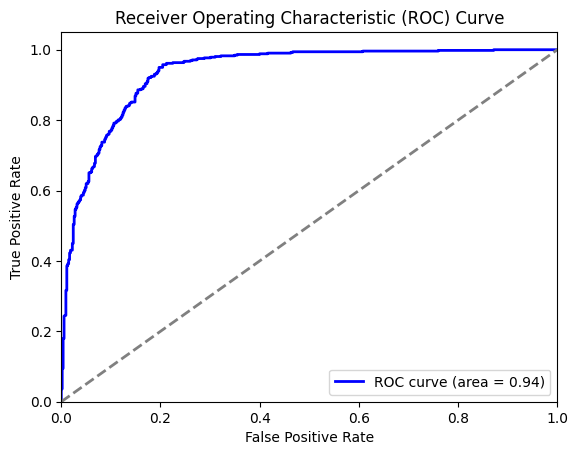

In [146]:
plt_roc(model)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


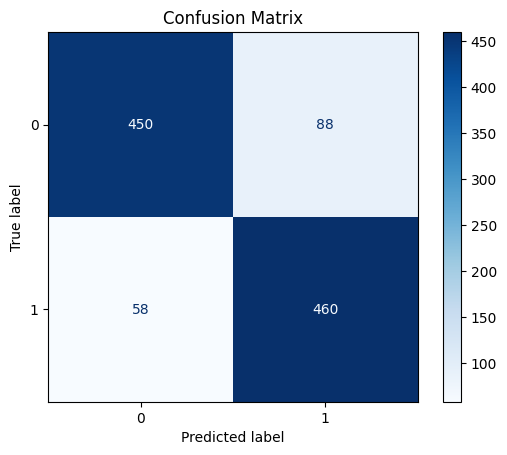

In [167]:
test_labels, test_pred_classes = plt_confusion(model)

In [168]:
report = classification_report(test_labels, test_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       538
           1       0.84      0.89      0.86       518

    accuracy                           0.86      1056
   macro avg       0.86      0.86      0.86      1056
weighted avg       0.86      0.86      0.86      1056



## Proposed Model with Dropout

In [149]:
myModel = Sequential()

myModel.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))

myModel.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))

myModel.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2),padding="same"))
myModel.add(Dropout(0.4))

myModel.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))
myModel.add(Dropout(0.2))

myModel.add(Flatten())

myModel.add(Dense(units=32, activation='relu', use_bias=True))
myModel.add(Dense(units=8, activation='relu', use_bias=True))
myModel.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

myModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

myModel.summary()


c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_83 (Conv2D)              │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,009 (269.57 KB)

 Trainable params: 69,009 (269.57 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
myHistory = myModel.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=32)

test_loss, test_acc = myModel.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7056 - loss: 0.5544 - val_accuracy: 0.8229 - val_loss: 0.4104
Epoch 2/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8225 - loss: 0.3933 - val_accuracy: 0.8220 - val_loss: 0.3823
Epoch 3/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8195 - loss: 0.3934 - val_accuracy: 0.8267 - val_loss: 0.3664
Epoch 4/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8265 - loss: 0.3790 - val_accuracy: 0.8580 - val_loss: 0.3711
Epoch 5/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8383 - loss: 0.3632 - val_accuracy: 0.8419 - val_loss: 0.3529
Epoch 6/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8491 - loss: 0.3491 - val_accuracy: 0.8419 - val_loss: 0.3537
Epoch 7/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8531 - loss: 0.3348 - val_accuracy: 0.8741 - val_loss: 0.2975
Epoch 8/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8686 - loss: 0.3053 - val_accuracy: 0.

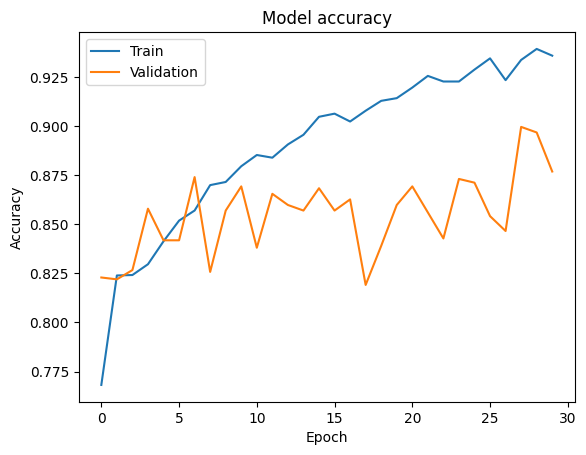

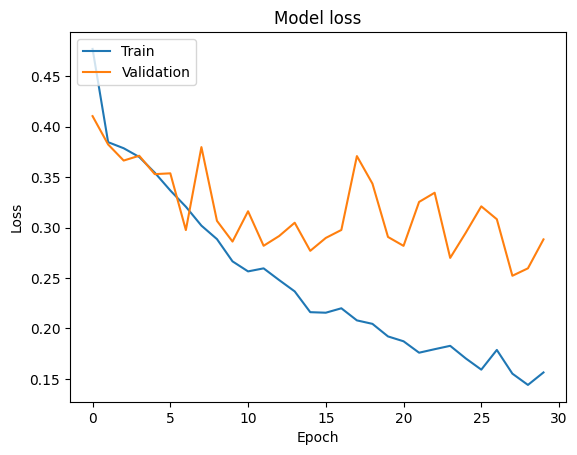

In [151]:
plt_acc_loss(myHistory)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


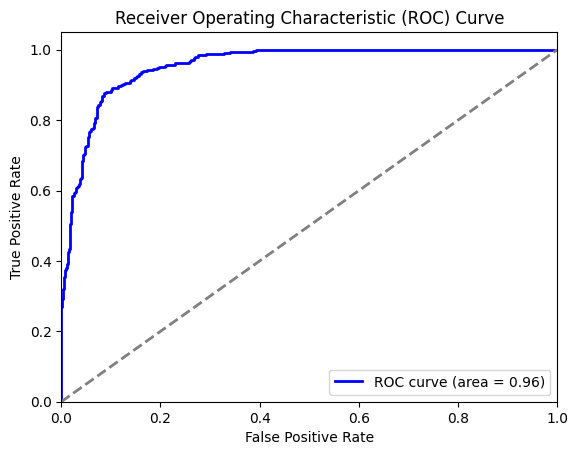

In [152]:
plt_roc(myModel)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


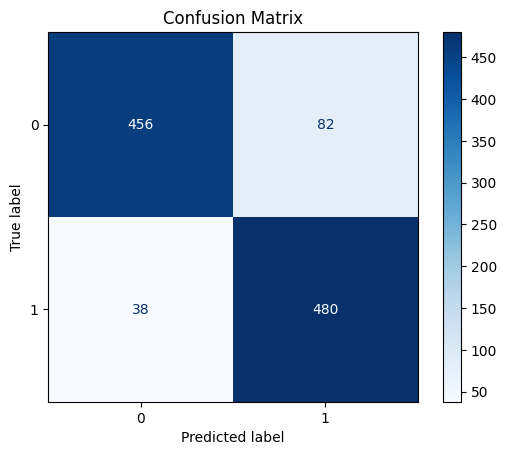

In [171]:
test_labels, test_pred_classes = plt_confusion(myModel)

In [172]:
report = classification_report(test_labels, test_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       538
           1       0.85      0.93      0.89       518

    accuracy                           0.89      1056
   macro avg       0.89      0.89      0.89      1056
weighted avg       0.89      0.89      0.89      1056



## Deeper Model

In [155]:
deeperNet = Sequential()

deeperNet.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))

deeperNet.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))

deeperNet.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2),padding="same"))
deeperNet.add(Dropout(0.4))

deeperNet.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))
deeperNet.add(Dropout(0.2))

deeperNet.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))
deeperNet.add(Dropout(0.2))

deeperNet.add(Flatten())

deeperNet.add(Dense(units=64, activation='relu', use_bias=True))
deeperNet.add(Dense(units=32, activation='relu', use_bias=True))
deeperNet.add(Dense(units=8, activation='relu', use_bias=True))
deeperNet.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

deeperNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

deeperNet.summary()


c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_87 (Conv2D)              │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,633 (998.57 KB)

 Trainable params: 255,633 (998.57 KB)

 Non-trainable params: 0 (0.00 B)

In [156]:
deeperHistory = deeperNet.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=128)

test_loss, test_acc = deeperNet.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6922 - loss: 0.5550 - val_accuracy: 0.8229 - val_loss: 0.4330
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8290 - loss: 0.3858 - val_accuracy: 0.8305 - val_loss: 0.3833
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8318 - loss: 0.3804 - val_accuracy: 0.8172 - val_loss: 0.4310
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8449 - loss: 0.3570 - val_accuracy: 0.8134 - val_loss: 0.3959
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8386 - loss: 0.3687 - val_accuracy: 0.8466 - val_loss: 0.3285
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8440 - loss: 0.3582 - val_accuracy: 0.8608 - val_loss: 0.3267
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8720 - loss: 0.3168 - val_accuracy: 0.8627 - val_loss: 0.3265
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8711 - loss: 0.3067 - val_accuracy: 0.

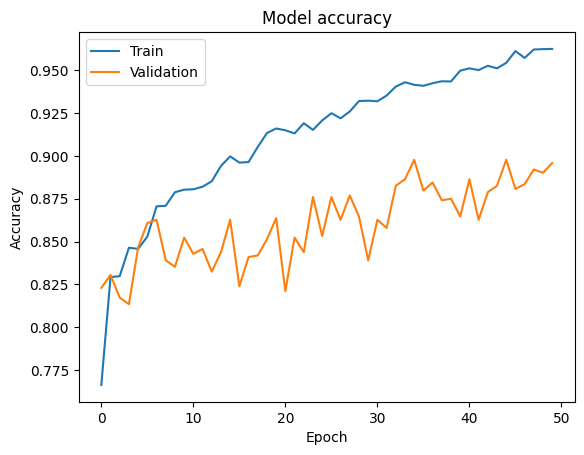

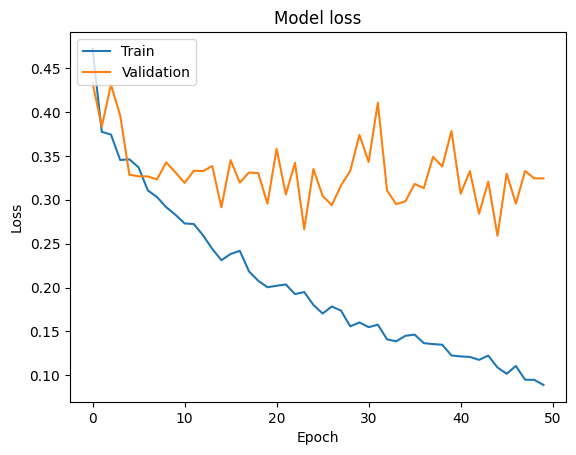

In [157]:
plt_acc_loss(deeperHistory)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


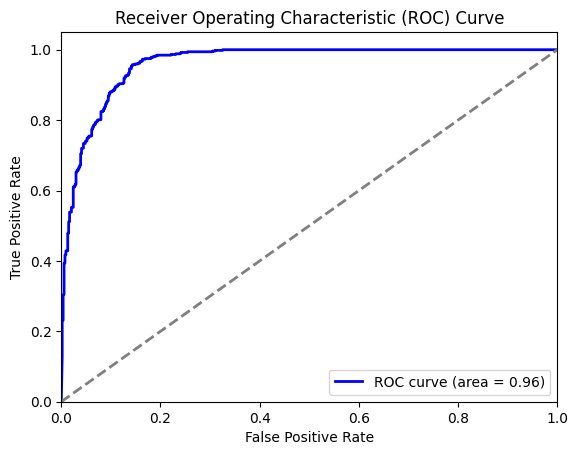

In [158]:
plt_roc(deeperNet)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


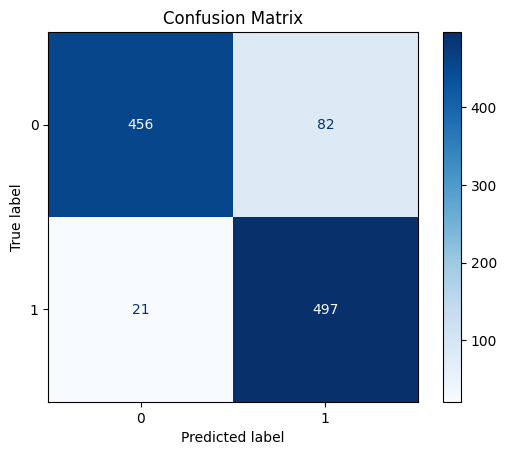

In [169]:
test_labels, test_pred_classes = plt_confusion(deeperNet)

In [170]:
report = classification_report(test_labels, test_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       538
           1       0.86      0.96      0.91       518

    accuracy                           0.90      1056
   macro avg       0.91      0.90      0.90      1056
weighted avg       0.91      0.90      0.90      1056

